# My first TF Neural network

## Data loading

Using TensorFlow backend.


(50000, 28, 28) (50000,)


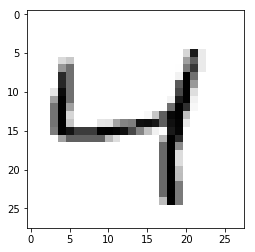

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.imshow(X_train[2], cmap="Greys");
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

In [2]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)
(10000, 784)


In [3]:
X_train=np.vstack([X_train,X_val])
y_train=np.hstack([y_train,y_val])
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


## Training

In [34]:
import tensorflow as tf
import numpy as np
#from tqdm import trange
from itertools import cycle

N_NUMBERS = int(np.unique(y_train).shape[0])
N_VARS    = X_train.shape[1]
BATCH_SIZE = 128
N_NEURONS = 200
N_NEURONS_F2=120
N_NEURONS_F=50
NRUNS = 5000
DSTEP = 100

s = tf.InteractiveSession()

# Placeholders for the input data
input_X = tf.placeholder("float32",shape=[None,784])
input_y = tf.placeholder("int32")
y_ = tf.one_hot(input_y,depth=N_NUMBERS)# The model code

#### INPUT LAYER ####
ACTIVATION=tf.nn.relu

# Model parameters - weights and bias
W = tf.Variable(initial_value=tf.truncated_normal((N_VARS,N_NEURONS),stddev=0.1),dtype="float32")
b = tf.Variable(initial_value=tf.truncated_normal((1,N_NEURONS),stddev=0.1),dtype="float32")

# Compute a vector of predictions, resulting shape should be [input_X.shape[0],]
# This is 1D, if you have extra dimensions, you can  get rid of them with tf.squeeze .
y1 = ACTIVATION(tf.matmul(input_X,W)+b)

#### HIDDEN LAYER(s) ####




W2b = tf.Variable(initial_value=tf.truncated_normal((N_NEURONS,N_NEURONS),stddev=0.1),dtype="float32")
b2b = tf.Variable(initial_value=tf.truncated_normal((1,N_NEURONS),stddev=0.1),dtype="float32")
y2b = ACTIVATION(tf.matmul(y1,W2b)+b2b)


W2a = tf.Variable(initial_value=tf.truncated_normal((N_NEURONS,N_NEURONS_F2),stddev=0.1),dtype="float32")
b2a = tf.Variable(initial_value=tf.truncated_normal((1,N_NEURONS_F2),stddev=0.1),dtype="float32")
y2a = ACTIVATION(tf.matmul(y2b,W2a)+b2a)

W2 = tf.Variable(initial_value=tf.truncated_normal((N_NEURONS_F2,N_NEURONS_F),stddev=0.1),dtype="float32")
b2 = tf.Variable(initial_value=tf.truncated_normal((1,N_NEURONS_F),stddev=0.1),dtype="float32")
y2 = ACTIVATION(tf.matmul(y2a,W2)+b2)

#### OUTPUT LAYER ####

W3 = tf.Variable(initial_value=tf.truncated_normal((N_NEURONS_F,N_NUMBERS),stddev=0.1),dtype="float32")
b3 = tf.Variable(initial_value=tf.truncated_normal((1,N_NUMBERS),stddev=0.1),dtype="float32")
y3_=tf.matmul(y2,W3)+b3
y3 = tf.nn.softmax(y3_)

## Training set decay ##
global_step = tf.Variable(0, trainable=False)
boundaries = [100,200,2000,4000]
values = [0.01, 0.003, 0.005,0.002]
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
#learning_rate=1e-2

# Loss. Should be a scalar number - average loss over all the objects
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y3_))
#loss =  tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y3), axis=1))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        loss,global_step=global_step)
predicted = tf.cast(tf.argmax(y3,axis=1),"int32")
accuracy = tf.reduce_mean(tf.cast(tf.equal(input_y,predicted),"float32"))

s.run(tf.global_variables_initializer())
s.run(tf.local_variables_initializer())



train_loss=[]
test_accuracy=[]
train_accuracy=[]
test_loss=[]

batch_train_cycle=cycle(np.random.permutation(np.arange(0,X_train.shape[0])))
batch_test_cycle=cycle(np.random.permutation(np.arange(0,X_test.shape[0])))

In [35]:
for i in range(NRUNS):
#for i in trange(NRUNS): 

    batch_train=[next(batch_train_cycle) for i in range(BATCH_SIZE)]
    batch_test=[next(batch_test_cycle) for i in range(BATCH_SIZE)]
    
    X_test_mini = X_test[batch_test,:]
    y_test_mini = y_test[batch_test]  
    
    X_train_mini = X_train[batch_train,:]
    y_train_mini = y_train[batch_train] 
    
    s.run(optimizer, {input_X: X_train_mini, input_y: y_train_mini})
    if i % DSTEP ==0:
        train_loss_i = s.run(loss, {input_X: X_train_mini, input_y: y_train_mini})
        test_loss_i = s.run(loss,{input_X: X_test_mini, input_y: y_test_mini})
        train_accuracy_i = s.run(accuracy, {input_X: X_train_mini, input_y: y_train_mini})
        test_accuracy_i  = s.run(accuracy,{input_X: X_test_mini, input_y: y_test_mini})
        train_accuracy.append(train_accuracy_i)
        test_accuracy.append(test_accuracy_i)
        train_loss.append(train_loss_i)
        test_loss.append(test_loss_i)
    if i % (DSTEP*10)==0:
        print("Iteration N: "+str(i))
    



Iteration N: 0
Iteration N: 1000
Iteration N: 2000
Iteration N: 3000
Iteration N: 4000


## Evaluation

Final accuracy:0.9819999933242798


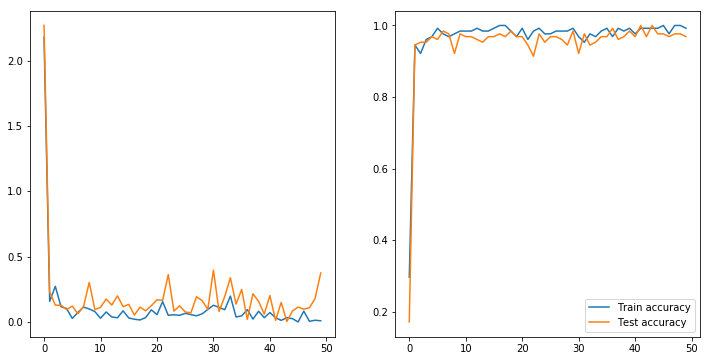

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label="Train loss")
plt.plot(test_loss,label="Test loss")
plt.subplot(1,2,2)
plt.plot(train_accuracy,label="Train accuracy")
plt.plot(test_accuracy,label="Test accuracy")
print("Final accuracy:{}".format(s.run(accuracy, {input_X: X_test, input_y: y_test})))
plt.legend()